100%|██████████| 170M/170M [00:01<00:00, 106MB/s]


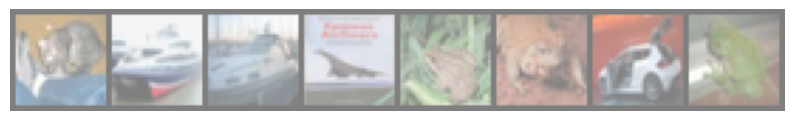

cat        ship       ship       airplane   frog       frog       automobile frog      


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the CIFAR-10 test (or training) dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)

# 2. Category names
classes = testset.classes  # ['airplane', 'automobile', 'bird', ..., 'truck']

# 3. Obtain a batch of images
dataiter = iter(testloader)
images, labels = next(dataiter)

# 4. Convert the images into a displayable format by transforming them from tensors to NumPy arrays
def imshow(img):
    img = img / 2 + 0.5  # Denormalization
    npimg = img.numpy()
    plt.figure(figsize=(10,2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# 5. Display the images along with their labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:10s}' for j in range(8)))


In [2]:
############################
# 1. Import dependencies and configure the GPU
############################

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

from sklearn.metrics import confusion_matrix, classification_report
import itertools

import time
import copy

# Verify GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
############################
# 2. Data Preparation, CIFAR-10 with Data Augmentation
############################

batch_size = 128

# Data augmentation on the training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # CIFAR-10 mean
                         (0.2470, 0.2435, 0.2616))  # CIFAR-10 variance
])

# Only normalization is applied to the test/validation set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

# Load the dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_test)

# We split the training set into a true training set and a validation set
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Construct the DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

print("Train Dataset size:", len(train_dataset))
print("Val Dataset size:  ", len(val_dataset))
print("Test Dataset size: ", len(test_dataset))

Train Dataset size: 45000
Val Dataset size:   5000
Test Dataset size:  10000


In [4]:
############################
# 3. Model definition
#    (VGG16、Inception v1、Wide ResNet、DenseNet)
############################

# ------ 3.1 VGG16  ------
from torchvision.models import vgg16

def build_vgg16(num_classes=10):
    # Setting weights=None is equivalent to the previous pretrained=False
    model = vgg16(weights=None)
    # Replace the final classification layer
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

# ------ 3.2 Inception v1 (GoogLeNet) ------
# Moderately simplified to accommodate 32×32 inputs
# Inception v1 requires training for multiple epochs before its performance becomes evident
class InceptionModuleBN(nn.Module):

    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModuleBN, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU(True),
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1, bias=False),
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU(True),
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1, bias=False),
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(True),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(True),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        return torch.cat([out1, out2, out3, out4], 1)


class InceptionV1CIFAR(nn.Module):
    """
    A modified version of Inception v1 tailored for the CIFAR-10 dataset:
    1）Batch Normalization (BN) was added after each convolutional layer.
    2）Each Inception module was augmented with internal Batch Normalization layers
    3）Pooling layers were adjusted with less aggressive downsampling to maintain spatial resolution
    4）The model utilized a tailored weight initialization strategy
    """
    def __init__(self, num_classes=10):
        super(InceptionV1CIFAR, self).__init__()

        # Added batch Normalization after the first two convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(True)
        )

        # Initial pooling operation, 16×16
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception 3a/3b
        self.inception3a = InceptionModuleBN(192, 64,  96, 128, 16,  32, 32)
        self.inception3b = InceptionModuleBN(256, 128, 128, 192, 32,  96, 64)

        # The second pooling layer reduced the spatial dimensions to 8×8
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception 4a ~ 4e
        self.inception4a = InceptionModuleBN(480, 192,  96, 208, 16,  48, 64)
        self.inception4b = InceptionModuleBN(512, 160, 112, 224, 24,  64, 64)
        self.inception4c = InceptionModuleBN(512, 128, 128, 256, 24,  64, 64)
        self.inception4d = InceptionModuleBN(512, 112, 144, 288, 32,  64, 64)
        self.inception4e = InceptionModuleBN(528, 256, 160, 320, 32, 128, 128)

        # The third pooling layer，reduced to 4×4
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception 5a/5b
        self.inception5a = InceptionModuleBN(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModuleBN(832, 384, 192, 384, 48, 128, 128)

        # Global Average Pooling followed by a Classification Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """
        All convolutional layers were initialized using Kaiming Normal initialization，
        The learnable scale parameters of Batch Normalization were initialized to 1,
        and the bias terms were initialized to 0
        The fully connected layers were initialized using a standard normal distribution
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # The first two convolutional layers
        x = self.conv1(x)   # [B,64,32,32]
        x = self.conv2(x)   # [B,192,32,32]
        x = self.pool1(x)   # [B,192,16,16]

        # Inception(3a,3b)
        x = self.inception3a(x)  # [B,256,16,16]
        x = self.inception3b(x)  # [B,480,16,16]
        x = self.pool2(x)        # [B,480,8,8]

        # Inception(4a~4e)
        x = self.inception4a(x)  # [B,512,8,8]
        x = self.inception4b(x)  # [B,512,8,8]
        x = self.inception4c(x)  # [B,512,8,8]
        x = self.inception4d(x)  # [B,528,8,8]
        x = self.inception4e(x)  # [B,832,8,8]
        x = self.pool3(x)        # [B,832,4,4]

        # Inception(5a,5b)
        x = self.inception5a(x)  # [B,832,4,4]
        x = self.inception5b(x)  # [B,1024,4,4]

        # Global Average Pooling followed by a Classification Layer
        x = self.avgpool(x)      # [B,1024,1,1]
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def build_inceptionv1_cifar(num_classes=10):
    """
    Factory function: returns a modified version of Inception v1
    """
    return InceptionV1CIFAR(num_classes=num_classes)


# ------ 3.3 Wide ResNet custom implementation ------

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, out_planes, stride=1, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.shortcut = (None if self.equalInOut else
                         nn.Conv2d(in_planes, out_planes,
                                   kernel_size=1, stride=stride, padding=0, bias=False))

    def forward(self, x):
        # Explicit if/else statements
        if not self.equalInOut:
            x = self.relu(self.bn1(x))
            out = self.conv1(x)
        else:
            out = self.relu(self.bn1(x))
            out = self.conv1(out)

        out = self.relu(self.bn2(out))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)

        return torch.add(x if self.shortcut is None else self.shortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        layers = []
        for i in range(nb_layers):
            layers.append(block(
                in_planes if i==0 else out_planes,
                out_planes,
                stride if i==0 else 1,
                dropRate))
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth=28, widen_factor=10, dropRate=0.0, num_classes=10):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert ((depth - 4) % 6 == 0), "Depth should be 6n+4"
        n = (depth - 4) // 6

        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], BasicBlock, 1, dropRate)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], BasicBlock, 2, dropRate)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], BasicBlock, 2, dropRate)

        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, (1,1))
        out = out.view(-1, out.size(1))
        return self.fc(out)

def build_wide_resnet(num_classes=10):
    return WideResNet(depth=28, widen_factor=10, dropRate=0.3, num_classes=num_classes)


# ------ 3.4 DenseNet  ------
from torchvision.models import densenet121

def build_densenet(num_classes=10):
    model = densenet121(weights=None)
    # Replace the final classification layer
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    return model


# ------ model factory function ------
def get_model(model_name, num_classes=10):
    if model_name.lower() == 'vgg16':
        return build_vgg16(num_classes)
    elif model_name.lower() == 'inceptionv1':
        return build_inceptionv1(num_classes)
    elif model_name.lower() == 'wideresnet':
        return build_wide_resnet(num_classes)
    elif model_name.lower() == 'densenet':
        return build_densenet(num_classes)
    else:
        raise ValueError("Unknown model name!")

In [5]:
############################
# 4. Training and validation functions
############################

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, device,
                num_epochs=10, lr=0.01, momentum=0.9, weight_decay=5e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,
                          momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    history = {
        'train_loss': [],
        'train_acc':  [],
        'val_loss':   [],
        'val_acc':    []
    }

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}]  "
              f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  "
              f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}  "
              f"Time: {epoch_time:.2f}s")

    model.load_state_dict(best_model_wts)
    return model, history

In [6]:
############################
# 5. Visualization function
############################

def plot_curves(history, model_name="Model"):
    # Loss curve
    plt.figure()
    plt.title(f"{model_name} - Loss Curve")
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Accuracy curve
    plt.figure()
    plt.title(f"{model_name} - Accuracy Curve")
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'],   label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.title(f"{model_name} - Confusion Matrix")
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
def get_model(model_name, num_classes=10):
    if model_name.lower() == 'vgg16':
        return build_vgg16(num_classes)
    elif model_name.lower() == 'inceptionv1':
        # Call build_inceptionv1_cifar instead of build_inceptionv1
        return build_inceptionv1_cifar(num_classes)
    elif model_name.lower() == 'wideresnet':
        return build_wide_resnet(num_classes)
    elif model_name.lower() == 'densenet':
        return build_densenet(num_classes)
    else:
        raise ValueError("Unknown model name!")

Training model: vgg16
Epoch [1/50]  Train Loss: 2.0338  Train Acc: 0.2132  Val Loss: 1.8852  Val Acc: 0.2808  Time: 11.36s
Epoch [2/50]  Train Loss: 1.6126  Train Acc: 0.3853  Val Loss: 1.4948  Val Acc: 0.4394  Time: 10.61s
Epoch [3/50]  Train Loss: 1.3623  Train Acc: 0.5027  Val Loss: 1.2374  Val Acc: 0.5502  Time: 10.04s
Epoch [4/50]  Train Loss: 1.1576  Train Acc: 0.5831  Val Loss: 1.0536  Val Acc: 0.6234  Time: 9.63s
Epoch [5/50]  Train Loss: 1.0121  Train Acc: 0.6386  Val Loss: 0.9319  Val Acc: 0.6746  Time: 10.15s
Epoch [6/50]  Train Loss: 0.8909  Train Acc: 0.6889  Val Loss: 0.8731  Val Acc: 0.6896  Time: 9.74s
Epoch [7/50]  Train Loss: 0.8113  Train Acc: 0.7176  Val Loss: 0.7941  Val Acc: 0.7270  Time: 9.71s
Epoch [8/50]  Train Loss: 0.7430  Train Acc: 0.7437  Val Loss: 0.7108  Val Acc: 0.7574  Time: 9.67s
Epoch [9/50]  Train Loss: 0.6778  Train Acc: 0.7669  Val Loss: 0.7366  Val Acc: 0.7514  Time: 9.81s
Epoch [10/50]  Train Loss: 0.6316  Train Acc: 0.7832  Val Loss: 0.6416  Va

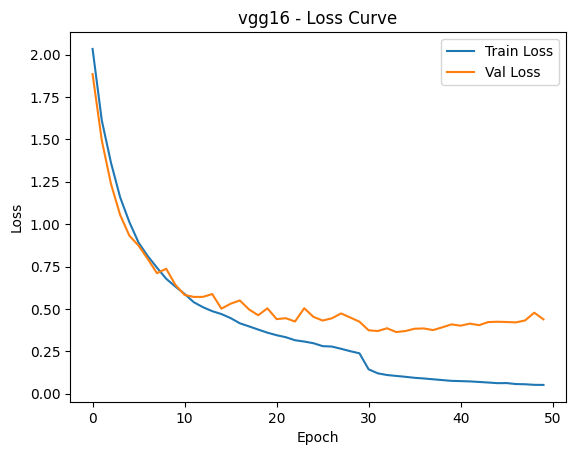

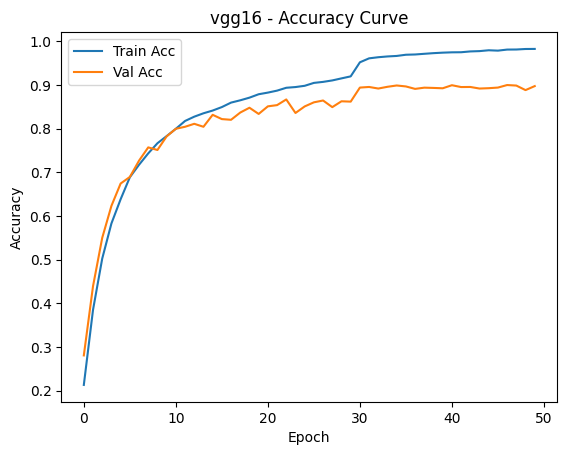

vgg16 Test Loss: 0.4250, Test Acc: 0.8946


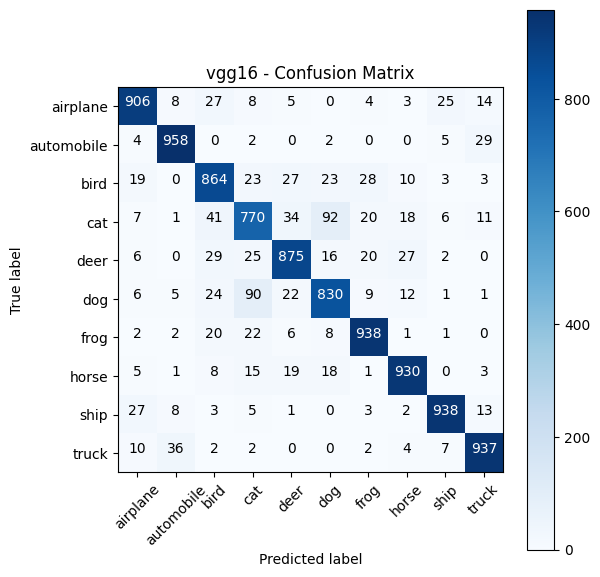

Classification Report for vgg16:
              precision    recall  f1-score   support

    airplane       0.91      0.91      0.91      1000
  automobile       0.94      0.96      0.95      1000
        bird       0.85      0.86      0.86      1000
         cat       0.80      0.77      0.78      1000
        deer       0.88      0.88      0.88      1000
         dog       0.84      0.83      0.83      1000
        frog       0.92      0.94      0.93      1000
       horse       0.92      0.93      0.93      1000
        ship       0.95      0.94      0.94      1000
       truck       0.93      0.94      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Training model: inceptionv1
Epoch [1/50]  Train Loss: 1.5668  Train Acc: 0.4196  Val Loss: 1.3864  Val Acc: 0.5060  Time: 14.18s
Epoch [2/50]  Train Loss: 1.0810  Train Acc: 0.6131  Val Loss: 1.0952  Val Acc

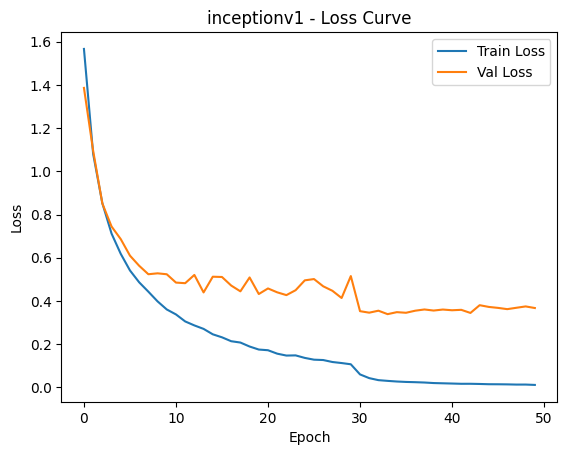

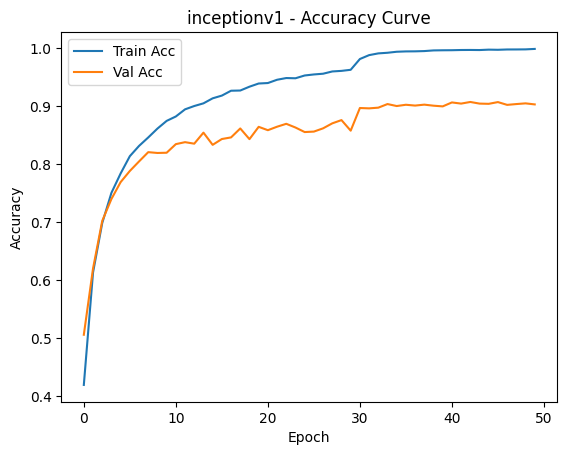

inceptionv1 Test Loss: 0.3767, Test Acc: 0.9008


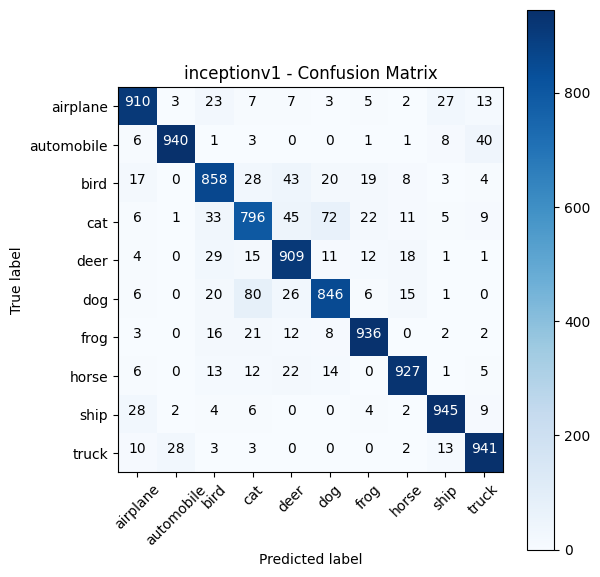

Classification Report for inceptionv1:
              precision    recall  f1-score   support

    airplane       0.91      0.91      0.91      1000
  automobile       0.97      0.94      0.95      1000
        bird       0.86      0.86      0.86      1000
         cat       0.82      0.80      0.81      1000
        deer       0.85      0.91      0.88      1000
         dog       0.87      0.85      0.86      1000
        frog       0.93      0.94      0.93      1000
       horse       0.94      0.93      0.93      1000
        ship       0.94      0.94      0.94      1000
       truck       0.92      0.94      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


Training model: wideresnet
Epoch [1/50]  Train Loss: 1.8021  Train Acc: 0.3101  Val Loss: 2.1064  Val Acc: 0.3162  Time: 28.05s
Epoch [2/50]  Train Loss: 1.3888  Train Acc: 0.4877  Val Loss: 1.5012  Va

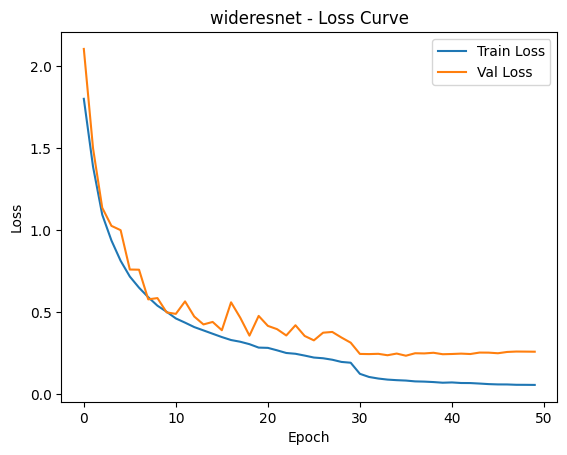

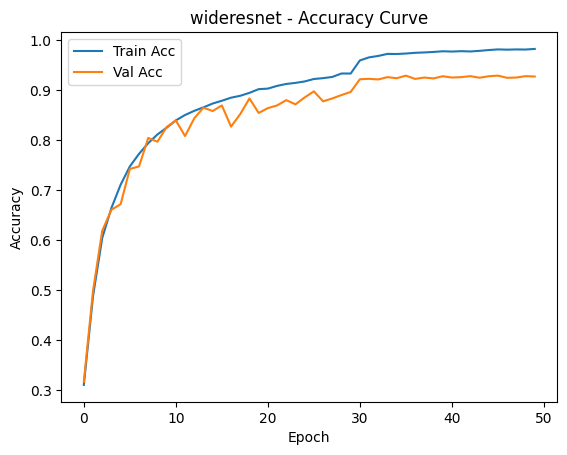

wideresnet Test Loss: 0.2577, Test Acc: 0.9282


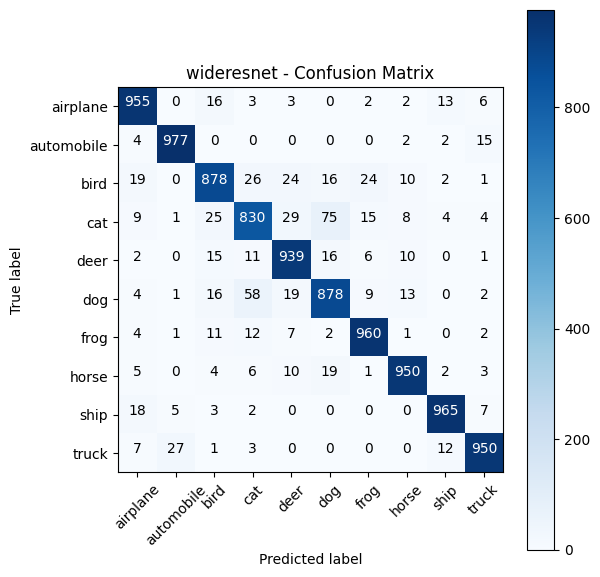

Classification Report for wideresnet:
              precision    recall  f1-score   support

    airplane       0.93      0.95      0.94      1000
  automobile       0.97      0.98      0.97      1000
        bird       0.91      0.88      0.89      1000
         cat       0.87      0.83      0.85      1000
        deer       0.91      0.94      0.92      1000
         dog       0.87      0.88      0.88      1000
        frog       0.94      0.96      0.95      1000
       horse       0.95      0.95      0.95      1000
        ship       0.96      0.96      0.96      1000
       truck       0.96      0.95      0.95      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


Training model: densenet
Epoch [1/50]  Train Loss: 1.6914  Train Acc: 0.3794  Val Loss: 1.6067  Val Acc: 0.4234  Time: 24.43s
Epoch [2/50]  Train Loss: 1.3653  Train Acc: 0.5046  Val Loss: 1.3114  Val A

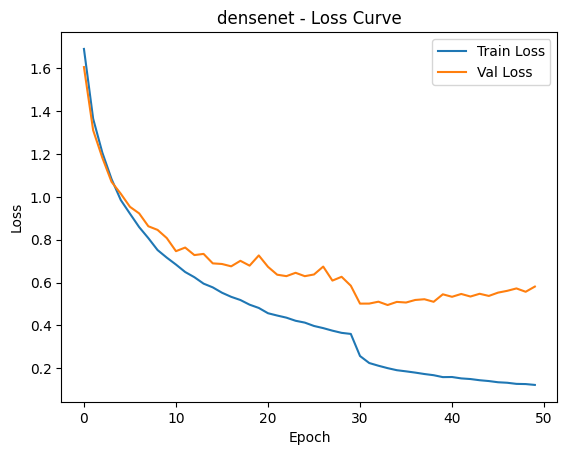

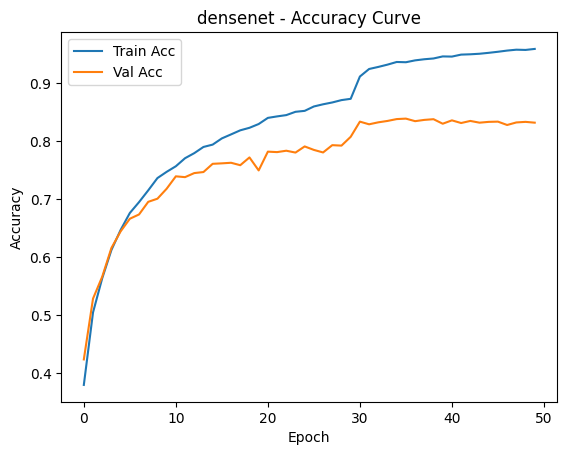

densenet Test Loss: 0.4992, Test Acc: 0.8462


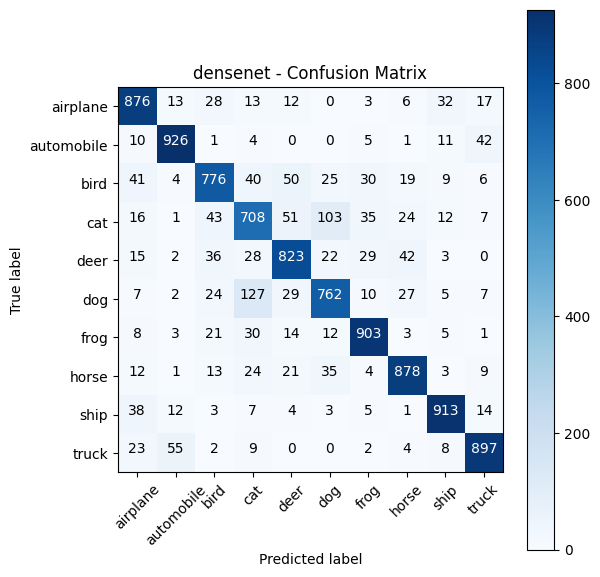

Classification Report for densenet:
              precision    recall  f1-score   support

    airplane       0.84      0.88      0.86      1000
  automobile       0.91      0.93      0.92      1000
        bird       0.82      0.78      0.80      1000
         cat       0.72      0.71      0.71      1000
        deer       0.82      0.82      0.82      1000
         dog       0.79      0.76      0.78      1000
        frog       0.88      0.90      0.89      1000
       horse       0.87      0.88      0.88      1000
        ship       0.91      0.91      0.91      1000
       truck       0.90      0.90      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Overall Comparison on Test Accuracy:
vgg16: 0.8946
inceptionv1: 0.9008
wideresnet: 0.9282
densenet: 0.8462


In [8]:
############################
# 6. Main pipeline: train four models separately, followed by evaluation, visualization, and comparison
############################

model_names = ['vgg16', 'inceptionv1', 'wideresnet', 'densenet']
num_epochs = 50
all_results = {}

# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

for m_name in model_names:
    print("===========================================")
    print(f"Training model: {m_name}")
    print("===========================================")

    # Obtain and move to GPU
    model = get_model(m_name, num_classes=10).to(device)

    # Train the model
    model, history = train_model(
        model, train_loader, val_loader,
        device=device,
        num_epochs=num_epochs,
        lr=0.01,
        momentum=0.9,
        weight_decay=5e-4
    )

    # Plot the training curves
    plot_curves(history, model_name=m_name)

    # Evaluation on the test set
    test_loss, test_acc = validate(model, test_loader, nn.CrossEntropyLoss(), device)
    print(f"{m_name} Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    all_results[m_name] = test_acc

    # Compute the confusion matrix
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            y_true.extend(labels.tolist())
            y_pred.extend(preds.cpu().tolist())

    # Confusion matrix visualization
    plot_confusion_matrix(y_true, y_pred, class_names, model_name=m_name)

    # Classification report
    print(f"Classification Report for {m_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    print()

# Compare the final test accuracy of each model
print("===========================================")
print("Overall Comparison on Test Accuracy:")
for m_name, acc in all_results.items():
    print(f"{m_name}: {acc:.4f}")

In [9]:
import random
import math
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Denormalization is applied to restore images from the [0, 1] range to the original RGB range for visualization
# The official mean and standard deviation of CIFAR-10 are as follows
# Define an invertible Normalize function for visualization purposes
inv_transform = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.4914, 0.4822, 0.4465],
                               [0.2470, 0.2435, 0.2616])],
    std =[1.0/s for s in [0.2470, 0.2435, 0.2616]]
)

def visualize_cifar10_predictions(model, device, test_loader, class_names, num_images=6):
    """
    Retrieve a batch from the test loader, perform prediction using the model,
    and randomly select num_images images for visualization。
    :param model:       pretrained model
    :param device:      (CPU or GPU)
    :param test_loader: the test DataLoader
    :param class_names: list of class names, like['airplane', 'automobile', 'bird', ...]
    :param num_images:  The number of images to visualize
    """
    model.eval()

    # Retrieve a batch from the test loader
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Perform a forward pass to obtain predictions
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = outputs.max(1)

    # To randomly select samples, random.sample can be used with the range [0, batch_size)
    indices = list(range(images.size(0)))
    random.shuffle(indices)
    show_indices = indices[:num_images]

    # Create subplots
    rows = int(math.ceil(num_images / 3))  # Place 3 images per row
    fig, axs = plt.subplots(rows, 3, figsize=(10, 4 * rows))
    axs = axs.flatten()  # Flatten to one dimension for convenient indexing

    for i, idx in enumerate(show_indices):
        # Move the tensor from GPU to CPU and apply denormalization
        img = inv_transform(images[idx].cpu())
        # Convert the tensor shape from [C, H, W] to [H, W, C]
        img = img.permute(1, 2, 0).numpy()
        # Clip the values to the [0, 1] range
        img = np.clip(img, 0, 1)

        axs[i].imshow(img)
        true_label = class_names[labels[idx].item()]
        pred_label = class_names[preds[idx].item()]
        axs[i].set_title(f"True: {true_label}, Pred: {pred_label}")
        axs[i].axis('off')

    # Close unused subplots
    for j in range(i+1, len(axs)):
        axs[j].axis('off')
    plt.tight_layout()
    plt.show()

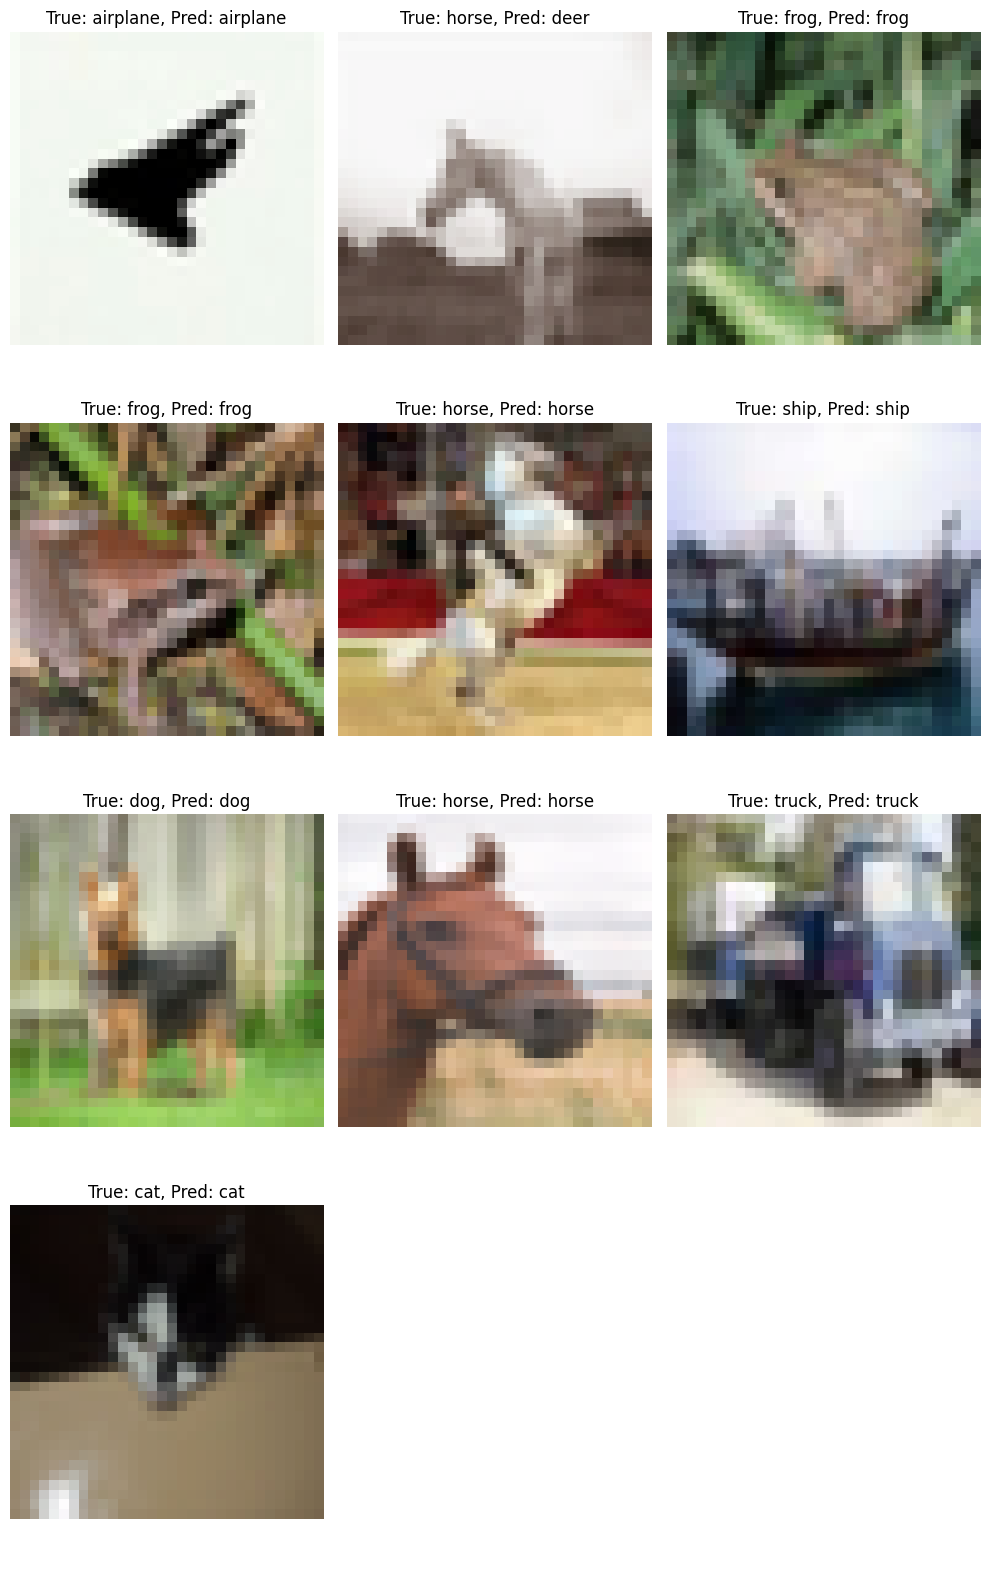

In [10]:
visualize_cifar10_predictions(model, device, test_loader, class_names, num_images=10)

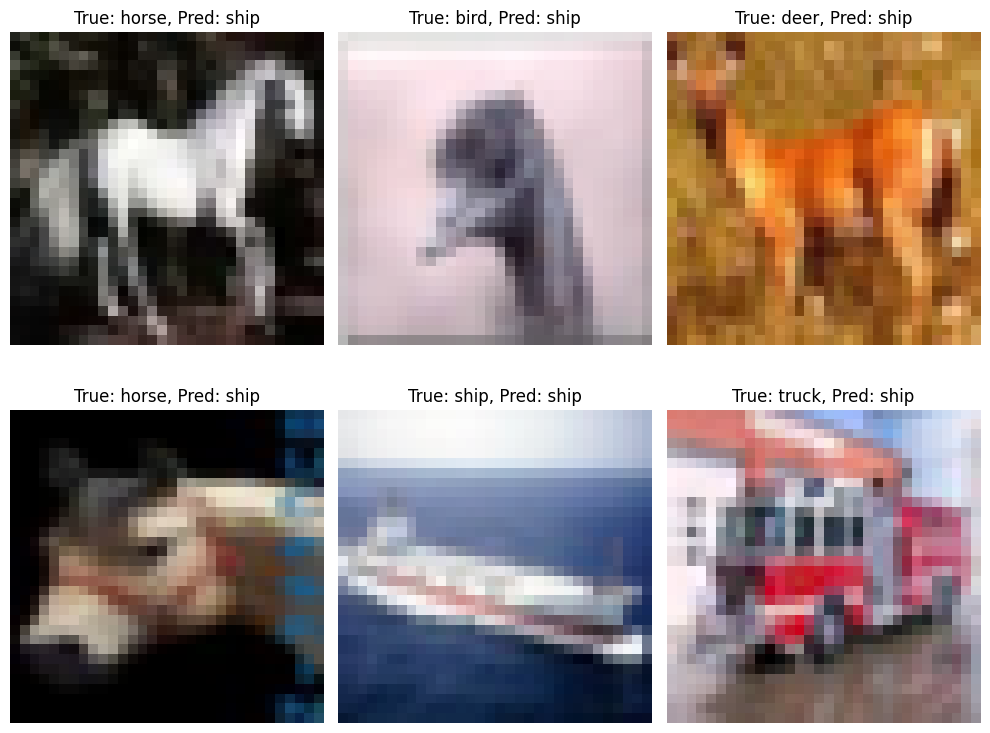

In [11]:
# Get VGG16 model:
vgg16_model = get_model('vgg16', num_classes=10).to(device)

# vgg16_model.load_state_dict(torch.load('path/to/vgg16_weights.pth')) # replace with the actual path

# Use vgg16_model for visualization
visualize_cifar10_predictions(vgg16_model, device, test_loader, class_names, num_images=6)

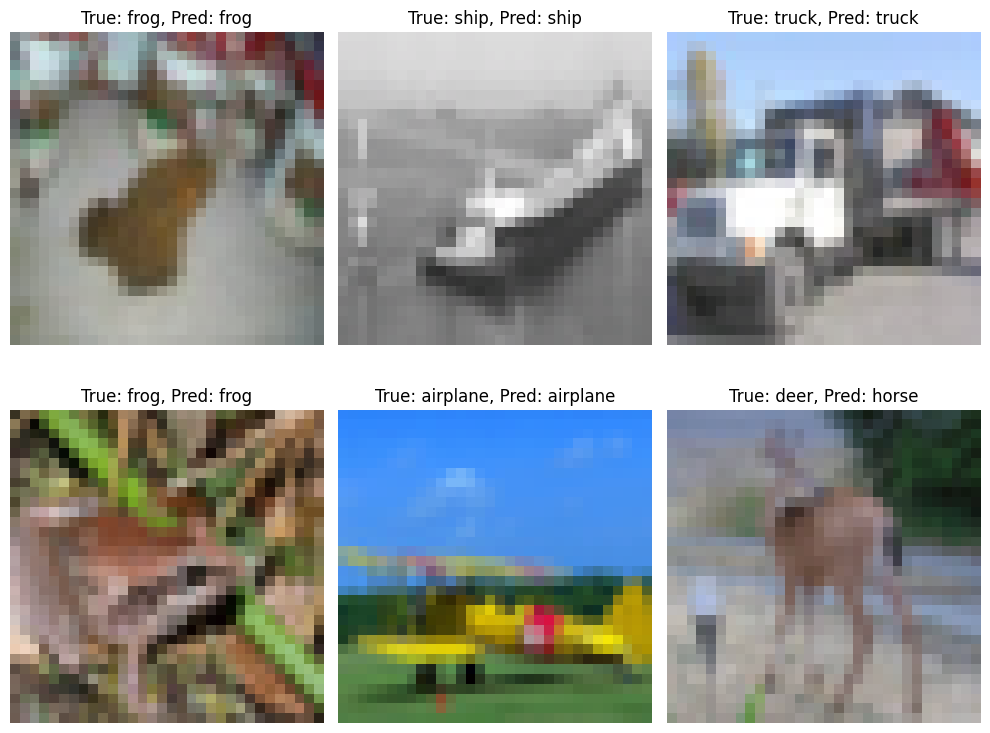

In [12]:
for m_name in model_names:

    # Store the trained model with appropriate name
    if m_name == 'inceptionv1':
        inception_model = model

# Use inception_model for visualization:
visualize_cifar10_predictions(inception_model, device, test_loader, class_names, num_images=6)